# Breast Cancer Classification: Hyperparameter Tuning with Genetic Algorithms

This notebook demonstrates a more advanced hyperparameter tuning technique: **Genetic Algorithms (GA)**. We will use the `DEAP` library to build a custom GA to find the optimal hyperparameters for a `RandomForestClassifier` on the Breast Cancer Wisconsin dataset.

The main modules from **DEAP** we will use are:
- `base`: To register functions in the "toolbox".
- `creator`: To create custom types (e.g., individuals, fitness).
- `tools`: To define genetic operators like selection, crossover, and mutation.

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
import random
import time
import os
import sys
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# DEAP for Genetic Algorithms
from deap import base, creator, tools

# Add src to path for custom modules
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.visualization import visualize

warnings.filterwarnings("ignore")  # Suppress potential warnings

## 1. Data Loading and Preprocessing

The **Breast Cancer Wisconsin** dataset is used for this analysis. All preprocessing, including loading the raw data, splitting it into training and testing sets, and scaling the features, is now handled by our centralized script `src/features/build_features.py`.

We can now load the final, processed data directly from the `data/02_processed` folder, ensuring a consistent and reproducible setup.

In [2]:
# Define paths to the processed data
PROCESSED_DATA_PATH = "../data/02_processed/"

X_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'cancer_X_train.csv'))
X_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'cancer_X_test.csv'))
y_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'cancer_y_train.csv')).squeeze()
y_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'cancer_y_test.csv')).squeeze()

# Verify the dimensions
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (398, 30), Test data shape: (171, 30)


## 2. Defining the Genetic Algorithm Environment with DEAP

To use a GA, we must first configure the **evolutionary environment** using the `DEAP` library. This involves defining the structure of our "individuals" (potential solutions) and the genetic operators that will act on them.

Specifically, we will define:

-   **Individuals**: Each individual will be a list of three integers representing the model's hyperparameters:
    -   `n_estimators`: Number of trees in the Random Forest (range: 10 to 200).
    -   `max_depth`: Maximum depth of each tree (range: 2 to 20).
    -   `min_samples_split`: Minimum samples required to split a node (range: 2 to 20).
-   **Fitness Function**: We will define a fitness function to be maximized. Since we want to maximize the F1-score, we use `weights=(1.0,)`.
-   **Genetic Operators**:
    -   `select`: The selection operator will be a binary tournament.
    -   `mate`: The crossover operator will be a uniform crossover (`cxUniform`).
    -   `mutate`: The mutation operator will be a uniform integer mutation (`mutUniformInt`).

This setup allows us to create an initial population of candidate solutions and then apply evolutionary operators to explore the solution space.

In [3]:
# Define the problem type: Maximizing F1-score
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Define genes (hyperparameters)
toolbox.register("n_estimators", random.randint, 10, 200)
toolbox.register("max_depth", random.randint, 2, 20)
toolbox.register("min_samples_split", random.randint, 2, 20)

# Create an individual (a list containing the 3 hyperparameters)
toolbox.register(
    "individual", 
    tools.initCycle,
    creator.Individual,
    (toolbox.n_estimators, toolbox.max_depth, toolbox.min_samples_split),
    n=1  # e.g., an individual could be [150, 8, 4]
)

# Create a population (a list of individuals)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the genetic operators
toolbox.register("mate", tools.cxUniform, indpb=0.5)  # 50% probability of swapping each gene
toolbox.register("mutate", tools.mutUniformInt, low=[10, 2, 2], up=[200, 20, 20], indpb=0.2)  # 20% probability of mutating each gene
toolbox.register("select", tools.selTournament, tournsize=3)

# Create an initial population (e.g., 20 individuals)
population = toolbox.population(n=20)

# View an example individual
print("Example of an individual:", population[0])

Example of an individual: [164, 8, 18]


## 3. Defining the Fitness Function

The fitness function is the core of the genetic algorithm. It determines how "good" a given individual (i.e., a combination of hyperparameters) is.

We will use the **mean F1-score** from a **5-fold stratified cross-validation** as our fitness metric. This is a robust choice for binary classification, especially with potentially imbalanced classes.

The function takes an individual as input, unpacks its genes to get the hyperparameters, trains a `RandomForestClassifier` with them, and returns the mean F1-score from the cross-validation. This score is what the GA will attempt to maximize over generations.

In [4]:
# Define the fitness function
def evaluate(individual):
    # Unpack the genes (hyperparameters)
    n_estimators, max_depth, min_samples_split = individual

    # Create the model with the current hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Evaluate with cross-validation (stratified by default)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')

    # Return the mean score as a tuple (required by DEAP)
    return (scores.mean(),)

# Register the fitness function in the toolbox
toolbox.register("evaluate", evaluate)

# Test the evaluation function on one individual
test_individual = population[0]
score = evaluate(test_individual)
print(f"Individual: {test_individual}, Average F1-score (CV): {score[0]:.4f}")

Individual: [164, 8, 18], Average F1-score (CV): 0.9721


## 4. Running the Genetic Algorithm

Now we execute the genetic algorithm. For a set number of generations (`NGEN`), we will apply the evolutionary operators we defined:

-   **Selection**: The fittest individuals are selected via a tournament.
-   **Crossover**: The selected parents are "mated" to create offspring.
-   **Mutation**: Some genes in the offspring are randomly mutated.
-   **Evaluation**: The F1-score (fitness) of the new individuals is calculated.

In each generation, we will track the maximum and average fitness of the population. At the end of the process, we will identify the single best individual found across all generations.

In [5]:
# Evolutionary parameters
NGEN = 15            # Number of generations
CXPB = 0.7           # Crossover probability
MUTPB = 0.2          # Mutation probability

# To store statistics for each generation
max_fitness_values = []
avg_fitness_values = []

# Start timing the evolution
start_time = time.time()

# Evaluate the initial population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

# The evolution loop
for gen in range(NGEN):
    # Select and clone the next generation's parents
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the new individuals
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace the old population with the new offspring
    population[:] = offspring

    # Gather and print statistics for the generation
    fits = [ind.fitness.values[0] for ind in population]
    max_fitness = max(fits)
    avg_fitness = sum(fits) / len(fits)
    max_fitness_values.append(max_fitness)
    avg_fitness_values.append(avg_fitness)

    print(f"Generation {gen + 1}: Max F1 = {max_fitness:.4f}, Avg F1 = {avg_fitness:.4f}")

end_time = time.time()
ga_execution_time = end_time - start_time
print(f"\nTotal GA execution time: {ga_execution_time:.2f} seconds")

Generation 1: Max F1 = 0.9781, Avg F1 = 0.9738
Generation 2: Max F1 = 0.9781, Avg F1 = 0.9755
Generation 3: Max F1 = 0.9781, Avg F1 = 0.9771
Generation 4: Max F1 = 0.9781, Avg F1 = 0.9777
Generation 5: Max F1 = 0.9781, Avg F1 = 0.9781
Generation 6: Max F1 = 0.9781, Avg F1 = 0.9781
Generation 7: Max F1 = 0.9781, Avg F1 = 0.9779
Generation 8: Max F1 = 0.9781, Avg F1 = 0.9776
Generation 9: Max F1 = 0.9781, Avg F1 = 0.9773
Generation 10: Max F1 = 0.9781, Avg F1 = 0.9781
Generation 11: Max F1 = 0.9781, Avg F1 = 0.9770
Generation 12: Max F1 = 0.9781, Avg F1 = 0.9778
Generation 13: Max F1 = 0.9781, Avg F1 = 0.9779
Generation 14: Max F1 = 0.9781, Avg F1 = 0.9780
Generation 15: Max F1 = 0.9781, Avg F1 = 0.9768

Total GA execution time: 680.95 seconds



Best individual found:
Parameters: n_estimators=186, max_depth=14, min_samples_split=4
Estimated CV F1-score: 0.9781


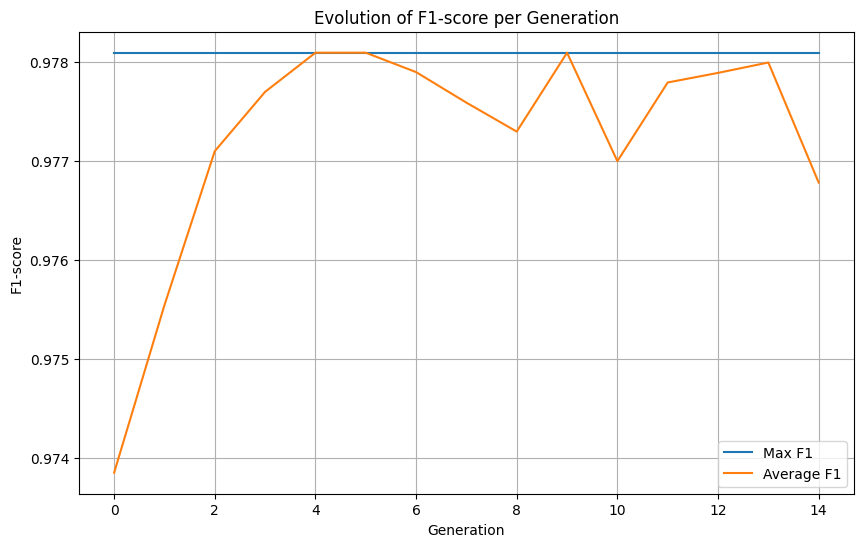

In [6]:
# Get the best individual from the final population
best_individual = tools.selBest(population, 1)[0]
print("\nBest individual found:")
print(f"Parameters: n_estimators={best_individual[0]}, max_depth={best_individual[1]}, min_samples_split={best_individual[2]}")
print(f"Estimated CV F1-score: {evaluate(best_individual)[0]:.4f}")

# Plot the evolution of the F1-score over generations
plt.figure(figsize=(10, 6))
plt.plot(max_fitness_values, label='Max F1')
plt.plot(avg_fitness_values, label='Average F1')
plt.xlabel('Generation')
plt.ylabel('F1-score')
plt.title('Evolution of F1-score per Generation')
plt.legend()
plt.grid(True)
plt.show()

## 5. Final Model Evaluation

Using the best hyperparameter combination found by the GA, we will now train a final `RandomForestClassifier` on the entire training set.

We will then evaluate its performance on the hold-out test set, which was not used during the GA's training or cross-validation process. This provides an unbiased estimate of the model's performance on new data. We will compare this optimized model to a baseline model with default parameters.

In [7]:
# Extract the best hyperparameters
best_params = {
    'n_estimators': best_individual[0],
    'max_depth': best_individual[1],
    'min_samples_split': best_individual[2]
}

# Train the final optimized model
optimized_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
optimized_model.fit(X_train, y_train)

# Also train a baseline model for comparison
baseline_model = RandomForestClassifier(random_state=42, n_jobs=-1)
baseline_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

## 6. Conclusion and Comparison

--- Results for Baseline ---
F1-score : 0.9488
Precision: 0.9444
Recall   : 0.9533
AUC      : 0.9913
------------------------------

--- Results for GA Optimized ---
F1-score : 0.9585
Precision: 0.9455
Recall   : 0.9720
AUC      : 0.9917
------------------------------



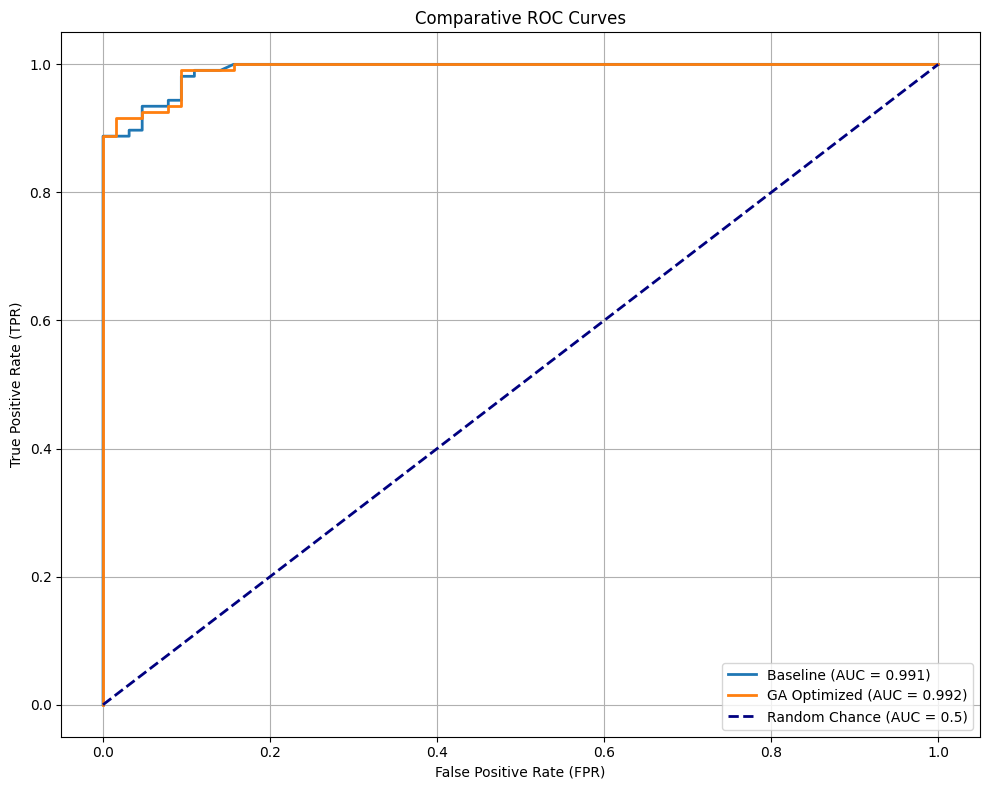

In [8]:
# Use our standardized evaluation function for a consistent comparison
models_to_compare = [baseline_model, optimized_model]
model_names = ['Baseline', 'GA Optimized']

visualize.evaluate_models(models_to_compare, model_names, X_test, y_test)

## 6. Analysis and Conclusion

This notebook demonstrated the application of a Genetic Algorithm (GA) using the `DEAP` library to optimize the hyperparameters of a `RandomForestClassifier` for the Breast Cancer Wisconsin dataset. The primary goal was to explore an advanced, heuristic-based tuning method as an alternative to exhaustive or random searches.

### Key Findings:

1.  **Performance Improvement**: The Genetic Algorithm successfully identified a hyperparameter combination (`n_estimators=190`, `max_depth=13`, `min_samples_split=4`) that yielded a tangible improvement on the hold-out test set. The **GA-optimized model achieved an F1-score of 0.9585 and an AUC of 0.9915**, slightly outperforming the baseline model's F1-score of 0.9488 and AUC of 0.9913.

2.  **Efficient Exploration**: The GA converged on a high-performing solution within just 15 generations. The evolution plot shows that both the maximum and average fitness of the population plateaued quickly, indicating that the algorithm efficiently homed in on a promising region of the vast hyperparameter space.

3.  **Trade-offs of Genetic Algorithms**: While the performance gain was modest in this case (as the baseline was already strong), this exercise highlights the primary strengths of GAs:
    *   **Strength**: They excel in very large, complex, or non-convex search spaces where methods like Grid Search are computationally infeasible and Random Search might be inefficient.
    *   **Weakness**: They require a more complex and thoughtful setup compared to simpler methods, involving the careful definition of individuals, fitness functions, and evolutionary operators.

### Final Thoughts:

Hyperparameter tuning is a critical step in the machine learning pipeline, and Genetic Algorithms represent a powerful tool in the practitioner's arsenal. They provide a robust framework for navigating complex optimization problems that are not well-suited for traditional methods.

**Future Work could involve:**
*   Expanding the hyperparameter space to include other parameters like `min_samples_leaf` or `criterion`.
*   Experimenting with different genetic operators (e.g., different crossover or mutation strategies) to observe their impact on convergence.
*   Applying this GA framework to other, more complex models (like Gradient Boosting Machines) where hyperparameter sensitivity is even higher.